# Apple stock value

One of my friends received a coding challenge for a job interview that asked him to develop a strategy to predict weekly change in Apple stock value and whether to invest, short or do nothing. I tried a few data science/ML trick to see if I could help. Moreover, instead of just having a prediction, I tried to have a confidence interval in the prediction, so that there is a way to incorporate risk in the strategy.

Without any surprise, this is an extremely challenging problem and I didn't have any much success. If I did, I wouldn't be here right now....

##### Load libraries

In [1]:
import pandas as pd
import numpy as np
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


##### Load historic data
I have Apple stock and SPYweekly change  

In [2]:
df = pd.read_excel("/media/vince/datascience/daniel_finance/ISA_Round Table Data Set.xlsx")

In [3]:
df.head()

,Apple,SPY
1993-02-06,-3.781495,2.345901
1993-02-13,-5.685598,-0.833937
1993-02-20,2.088162,-2.312496
1993-02-27,-3.636354,1.936864
1993-03-06,3.773575,0.774144


##### Look at stock variation over time

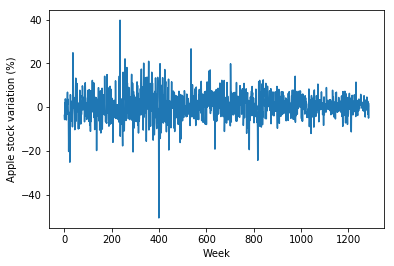

In [4]:
plt.plot(range(0,len(df)),df["Apple"])
plt.ylabel("Apple stock variation (%)")
plt.xlabel("Week")
plt.show()

For each stock entry, look at the previous week change. It is not clear how far back we should look, so I tried from 1 week to the previous 100 week

In [5]:
for i in range(1,100):
    df["Apple-"+str(i)] = list(df["Apple"][i:])+[NaN]*i
    #df["SPY-"+str(i)] = list(df["SPY"][i:])+[NaN]*i

Look at the correlation between Apple stock and previous week

In [6]:
cors = df.corr()["Apple"].sort_values(ascending=False)
print(cors.head(10))
print(cors.tail(10))


Apple       1.000000
SPY         0.393208
Apple-52    0.070943
Apple-9     0.063531
Apple-1     0.061248
Apple-3     0.059113
Apple-51    0.053933
Apple-10    0.050829
Apple-88    0.050449
Apple-16    0.043125
Name: Apple, dtype: float64
Apple-56   -0.034827
Apple-38   -0.035363
Apple-66   -0.037915
Apple-12   -0.038243
Apple-59   -0.042691
Apple-60   -0.045286
Apple-55   -0.057285
Apple-54   -0.060719
Apple-30   -0.062149
Apple-14   -0.084735
Name: Apple, dtype: float64


Apple


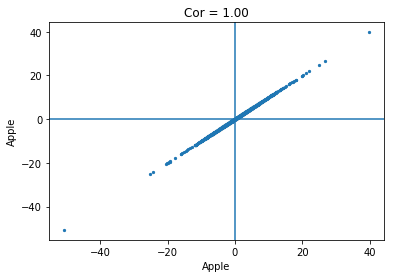

SPY


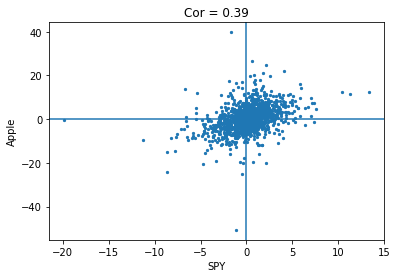

Apple-14


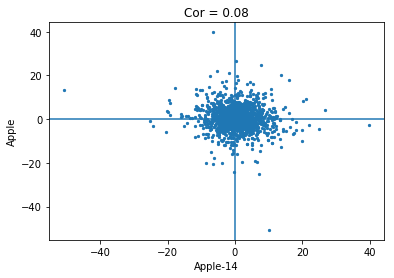

Apple-52


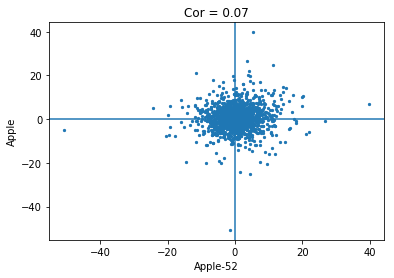

Apple-9


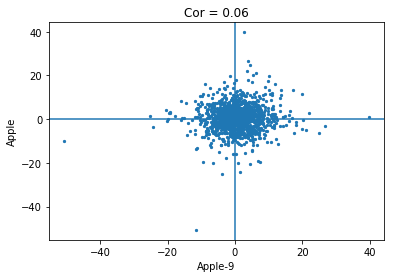

In [7]:
cors = df.corr().abs()["Apple"].sort_values(ascending=False)
for (lab,val) in zip(list(cors.index),cors.values)[0:5]:
    print(lab)
    plt.scatter(df[lab],df["Apple"],s=5)
    plt.xlabel(lab)
    plt.ylabel("Apple")
    plt.title("Cor = %.2f" % (val))
    plt.axhline(0)
    plt.axvline(0)
    plt.show()

Obviously, nothing correlate with the stock change. Trend might be more subtle

In [8]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

I will build some ML models. 

I have 1287 weeks of data. I will train/test on the 800 first week to find hyperparameter and then used the remaining 487 weeks has a holdout set to see how well my model would perform in real life.

In [9]:
print(len(df))
trainexp = 800

dftotrain = df.head(trainexp).tail(trainexp/2)
dftotest = df.tail(len(df)-trainexp)
print(len(dftotrain),len(dftotest))

1287
(400, 487)


I will first try some simple bayesian linear regression using previous week data

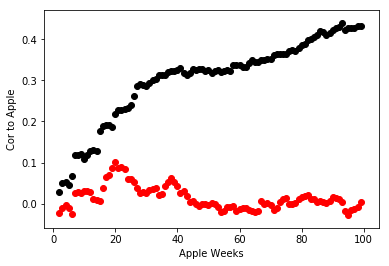

In [10]:
#Predict using values in past weeks
regr = linear_model.BayesianRidge()
topred = "Apple"
lab = "Apple"

AllPerformance = dict()
AllPerformance[topred+"_train"] = dict()
AllPerformance[topred+"_test"] = dict()

ModelName = "LinearRegression"

#Use 2 to 100 previous weeks
for i in range(2,100):
    xt = []
    for k in range(1,i):
        x = list(dftotrain[lab])[i-k:-k]
        xt.append(x)
    xt = np.array(xt)
    xt = np.transpose(xt)
    y = np.array(list(dftotrain[topred])[i:])
    regr.fit(xt,y)
    ypred = regr.predict(xt)
    cor = np.corrcoef(ypred,y)[0][1]
    #if cor > 0.29:
    #    plt.scatter(ypred,y)
    #    plt.show()
    NowModel = ModelName +" _weeks"+str(i)
    AllPerformance[topred+"_train"][NowModel] = cor
    plt.scatter(i,cor,c="black")


    xt = []
    for k in range(1,i):
        x = list(dftotest[lab])[i-k:-k]
        xt.append(x)
    xt = np.array(xt)
    xt = np.transpose(xt)
    y = np.array(list(dftotest[topred])[i:])

    [ypred,std] = regr.predict(xt,return_std=True)
    cor = np.corrcoef(ypred,y)[0][1]
    #if cor > 0.29:
    #    plt.scatter(ypred,y)
    #    plt.show()
    AllPerformance[topred+"_test"][NowModel] = cor
    plt.scatter(i,cor,c="red")
    #print(np.min(std))
plt.xlabel(lab+" Weeks")
plt.ylabel("Cor to "+topred)
plt.show()


Black is training dataset and red is testing
Model overfit!

Will use polynomial model

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

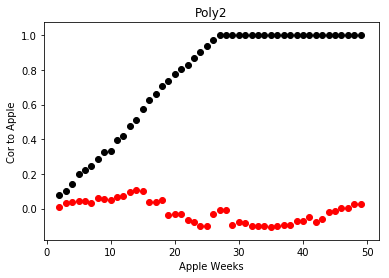

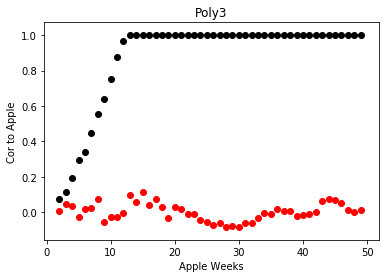

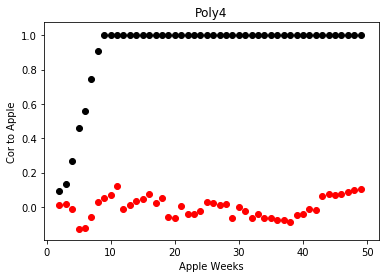

In [12]:
#Predict using values in past weeks
for d in range(2,5):
    regr = Pipeline([('poly', PolynomialFeatures(degree=d)), ('linear', LinearRegression(fit_intercept=False))])
    ModelName = "Poly"+str(d)
    for i in range(2,50):
        xt = []
        for k in range(1,i):
            x = list(dftotrain[lab])[i-k:-k]
            xt.append(x)
        xt = np.array(xt)
        xt = np.transpose(xt)
        y = np.array(list(dftotrain[topred])[i:])
        regr.fit(xt,y)
        ypred = regr.predict(xt)
        cor = np.corrcoef(ypred,y)[0][1]

        NowModel = ModelName +" _weeks"+str(i)
        AllPerformance[topred+"_train"][NowModel] = cor
        plt.scatter(i,cor,c="black")


        xt = []
        for k in range(1,i):
            x = list(dftotest[lab])[i-k:-k]
            xt.append(x)
        xt = np.array(xt)
        xt = np.transpose(xt)
        y = np.array(list(dftotest[topred])[i:])

        ypred = regr.predict(xt)
        cor = np.corrcoef(ypred,y)[0][1]
        #if cor > 0.29:
        #    plt.scatter(ypred,y)
        #    plt.show()
        AllPerformance[topred+"_test"][NowModel] = cor
        plt.scatter(i,cor,c="red")

    plt.title(ModelName)
    plt.xlabel(lab+" Weeks")
    plt.ylabel("Cor to "+topred)
    plt.show()


Model overfit!

In [13]:
from sklearn.neighbors import KNeighborsRegressor

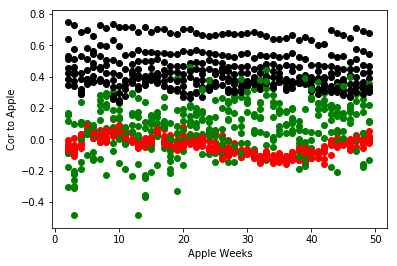

In [14]:
#Predict using values in past weeks

ModelName = "KNeighborsRegressor"
for i in range(2,50):
    for nn in range(2,10):
        xt = []
        for k in range(1,i):
            x = list(dftotrain[lab])[i-k:-k]
            xt.append(x)
        xt = np.array(xt)
        xt = np.transpose(xt)
        y = np.array(list(dftotrain[topred])[i:])

        neigh = KNeighborsRegressor(n_neighbors=nn)
        neigh.fit(xt,y)
        ypred = neigh.predict(xt)
        cor = np.corrcoef(ypred,y)[0][1]
        NowModel = ModelName +"NN"+str(nn)+" _weeks"+str(i)
        AllPerformance[topred+"_train"][NowModel] = cor
        plt.scatter(i,cor,c="black")


        xtt = []
        for k in range(1,i):
            x = list(dftotest[lab])[i-k:-k]
            xtt.append(x)
        xtt = np.array(xtt)
        xtt = np.transpose(xtt)
        ytt = np.array(list(dftotest[topred])[i:])

        ypred = neigh.predict(xtt)
        cor = np.corrcoef(ypred,ytt)[0][1]
        #if cor > 0.29:
        #    plt.scatter(ypred,y)
        #    plt.show()
        AllPerformance[topred+"_test"][NowModel] = cor
        plt.scatter(i,cor,c="red")

        dist = neigh.kneighbors(xtt)
        AllSTD = []
        for (ypreds) in zip(y[dist[1]]):
            AllSTD.append(np.std(ypreds))
        AllSTD = np.array(AllSTD)
        ind = np.argsort(AllSTD)
        top10per = int(len(ytt)/10)
        subcor = np.corrcoef(ypred[ind[0:top10per]],ytt[ind[0:top10per]])[0][1]
        plt.scatter(i,subcor,c="green")

plt.xlabel(lab+" Weeks")
plt.ylabel("Cor to "+topred)
plt.show()


In [15]:
pd.DataFrame(AllPerformance).sort_values("Apple_test",ascending=False).head(20)

,Apple_test,Apple_train
KNeighborsRegressorNN4 _weeks9,0.126873,0.507389
Poly4 _weeks11,0.122188,1.000000
Poly3 _weeks15,0.111397,1.000000
Poly2 _weeks14,0.106634,0.509336
Poly4 _weeks49,0.103409,1.000000
Poly2 _weeks15,0.102466,0.575569
LinearRegression _weeks20,0.100182,0.217220
Poly4 _weeks48,0.099015,1.000000
Poly3 _weeks13,0.098546,1.000000
KNeighborsRegressorNN6 _weeks5,0.098343,0.384708


The top models achieve only a 0.12 of correlation on the test set. Model tend to overfit as well. This is an incredibly hard challenge and we are working with only a fraction of available feature

Nonetheless, it was a good coding exercise!!

#### More data!

My friend gave me more data to work with and we also tried to define an investment strategy

In [16]:
df = pd.read_excel("/media/vince/datascience/daniel_finance/more_data.xlsx")
df = df.dropna()
df = df * 100.0

In [17]:
BenchMarkSize = 100
TrainingPercentage = 0.80

#Make all set

BenchDF = df.tail(BenchMarkSize)
SizeOfTrainingAndTesting = len(df)-BenchMarkSize

TrainingDF = df.head(int(TrainingPercentage*SizeOfTrainingAndTesting))

TestingDF = df.head(int(SizeOfTrainingAndTesting)).tail(int(SizeOfTrainingAndTesting*(1-TrainingPercentage)))


print(len(TrainingDF),len(TestingDF),len(BenchDF),len(TrainingDF)+len(TestingDF)+len(BenchDF),len(df))

(212, 52, 100, 364, 365)


In [18]:
def FormatData(df,w,ToPredict,ToUse,MaxWeek = 0):
    
    dftouse = df.tail(len(df)-MaxWeek+w)
    
    Yt = []
    Xt = []
    AllY = list(dftouse[ToPredict])


    for k in range(w,len(dftouse)):
        #print(k,AllY[k])

        xtemp = []
        for lab in ToUse:
            Subx = list(dftouse[lab])[k-w:k]
            xtemp.append(Subx)
        Xt.append(np.ravel(xtemp))
        Yt.append(AllY[k])
    return(Xt,np.array(Yt))

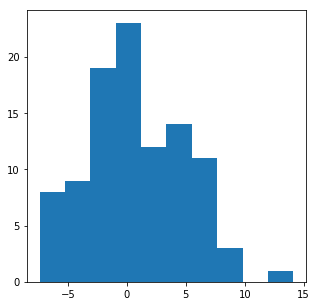

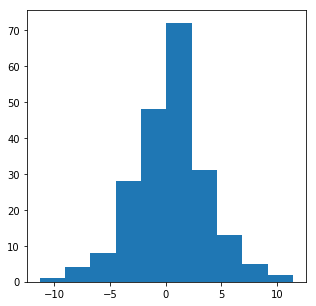

(-0.18477826937445568, 0.0, 16)
(-0.14573439496430876, 0.69999999999999996, 1)
(0.0, 0.80000000000000004, 0)
(0.046469863156645308, 0.0, 16)
(0.41629126124827714, 0.20000000000000001, 8)
(0.60494300069117446, 0.20000000000000001, 7)
(0.79943974009178431, 0.10000000000000001, 14)
(1.1894052714415617, 0.20000000000000001, 10)
(1.4691216864105177, 0.20000000000000001, 14)
(1.855340699877893, 0.0, 16)


In [19]:
from sklearn.preprocessing import scale
StockToPredict = "APPL"

figsize(5,5)
plt.hist(BenchDF[StockToPredict])
plt.show()
plt.hist(TrainingDF[StockToPredict])
plt.show()

DataToUse = list(df.columns)[1:]

WeeksToUse = range(2,50)
NNToUse = range(1,50)

WeeksToUse = np.array(range(1,10))*4
NNToUse = np.array(range(1,20))*5
#NNTpUse = range(2,4)
#WeeksToUse = range(10,11)

AllPerformance = dict()

BestModel = []
BestVal = -10

c = 0
for ToScale in [0,1]:
    for w in WeeksToUse:

        [Xt,Yt] = FormatData(TrainingDF,w,StockToPredict,DataToUse,MaxWeek = np.max(WeeksToUse))
        #Need to to some magick so that alway start same time given different W
        [X,Y] = FormatData(TestingDF,w,StockToPredict,DataToUse,MaxWeek = np.max(WeeksToUse))

        #Need to to some magick so that alway start same time given different W
        [oX,oY] = FormatData(BenchDF,w,StockToPredict,DataToUse,MaxWeek = np.max(WeeksToUse))
        
        if ToScale == 1:
            X = scale(X)
            Xt = scale(Xt)
            oX = scale(oX)
        
        for n in NNToUse:
            for weigs in ["uniform","distance"]:
            #for weigs in ["uniform"]:
                for p in [2]:
                #for p in range(1,5):
                    
                    neigh = KNeighborsRegressor(n_neighbors=n,weights=weigs,p=p)
                    neigh.fit(Xt,Yt)

                    Yp = neigh.predict(X)
                    cor = np.corrcoef(Yp,Y)[0][1]

                   

                    
                    
                    dist = neigh.kneighbors(X)
                    amean = []
                    astd = []
                    for di in dist[1]:
                        amean.append(np.mean(Yt[di]))
                        astd.append(np.std(Yt[di]))
                    amean = np.array(amean)
                    astd = np.array(astd)
                    
                    #Held out
                    oYp = neigh.predict(oX)
                    ocor = np.corrcoef(oYp,oY)[0][1]
                    dist = neigh.kneighbors(oX)
                    omean = []
                    ostd = []
                    for di in dist[1]:
                        omean.append(np.mean(Yt[di]))
                        ostd.append(np.std(Yt[di]))
                    omean = np.array(omean)
                    ostd = np.array(ostd)
                    
                    for risk in np.array(range(0,30))/10.0:
                        c += 1
                        AllPerformance[c] = dict()
                        ModelReturn = np.mean(Y*((np.array(Yp) > 0) * 2 - 1)*((np.abs(amean)-astd*risk) > 0))
                        if BestVal < ModelReturn:
                            BestVal = ModelReturn
                            print(ModelReturn,risk,np.sum((np.abs(amean)-astd*risk) > 0))
                        AllPerformance[c]["WeekInvest"] = np.sum((np.abs(amean)-astd*risk) > 0)
                        AllPerformance[c]["weeks"] = w
                        AllPerformance[c]["NN"] = n
                        AllPerformance[c]["cor"] = cor
                        AllPerformance[c]["ocor"] = ocor
                        AllPerformance[c]["weights"] = weigs
                        AllPerformance[c]["p"] = p
                        AllPerformance[c]["scale"] = ToScale
                        AllPerformance[c]["risk"] = risk
                        AllPerformance[c]["datapoint"] = len(Y)
                        AlwaysBuy = np.mean(Y)
                        AlwaysShort = np.mean(np.array(Y)*-1.0)
                        AlwaysKnow = np.mean(np.abs(Y))

                        AllPerformance[c]["ModelReturn"] = ModelReturn
                        AllPerformance[c]["AlwaysBuy"] = AlwaysBuy
                        
                        ModelReturn = np.mean(oY*((np.array(oYp) > 0) * 2 - 1)*((np.abs(omean)-ostd*risk) > 0))
                        AllPerformance[c]["oModelReturn"] = ModelReturn
                        AlwaysBuy = np.mean(oY)
                        AllPerformance[c]["oAlwaysBuy"] = AlwaysBuy
                        AllPerformance[c]["oDataPoint"] = len(oY)
                        AllPerformance[c]["oBestReturn"] = np.mean(np.abs(oY))
                    



                    

In [20]:
PerDF = pd.DataFrame(AllPerformance).transpose()

In [21]:

PerDF.sort_values(by="ModelReturn",ascending=False).head(10)

,AlwaysBuy,ModelReturn,NN,WeekInvest,cor,datapoint,oAlwaysBuy,oBestReturn,oDataPoint,oModelReturn,ocor,p,risk,scale,weeks,weights
10351,1.05401,1.85534,10,16,0.142376,16,0.581749,3.11037,64,0.544172,0.178481,2,0,1,4,distance
11461,1.05401,1.85534,10,16,0.322133,16,0.581749,3.11037,64,0.647057,0.159267,2,0,1,8,uniform
14071,1.05401,1.85534,35,16,0.189063,16,0.581749,3.11037,64,0.581749,0.0808686,2,0,1,16,distance
14041,1.05401,1.85534,35,16,0.203168,16,0.581749,3.11037,64,0.581749,0.0538434,2,0,1,16,uniform
11491,1.05401,1.85534,10,16,0.322938,16,0.581749,3.11037,64,0.647057,0.161082,2,0,1,8,distance
16081,1.05401,1.85534,15,16,0.287203,16,0.581749,3.11037,64,1.07864,0.316146,2,0,1,24,uniform
14011,1.05401,1.85534,30,16,0.0131167,16,0.581749,3.11037,64,0.32826,0.181067,2,0,1,16,distance
11581,1.05401,1.85534,20,16,0.194108,16,0.581749,3.11037,64,0.683543,0.142687,2,0,1,8,uniform
13981,1.05401,1.85534,30,16,0.023941,16,0.581749,3.11037,64,0.32826,0.163601,2,0,1,16,uniform
10441,1.05401,1.85534,20,16,0.0883038,16,0.581749,3.11037,64,0.451461,0.121391,2,0,1,4,uniform


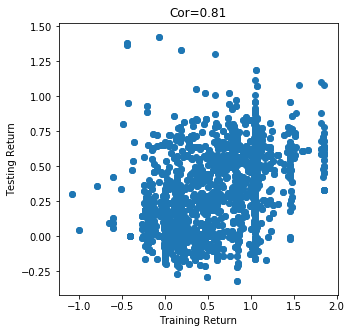

In [22]:
plt.scatter(PerDF["ModelReturn"],PerDF["oModelReturn"])
cor= np.corrcoef(PerDF["ModelReturn"].values.astype(float),PerDF["oModelReturn"].values.astype(float))[0][1]
plt.title("Cor=%.2f" % cor)
plt.xlabel("Training Return")
plt.ylabel("Testing Return")
plt.show()